# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
sum_exp = np.exp(5.1) + np.exp(3.2) + np.exp(-1.7)
normalized = [np.exp(3.2), np.exp(5.1), np.exp(-1.7)]/sum_exp
print(normalized)

[0.12998254 0.86904954 0.00096793]


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))



loss: 2.346917
sanity check: 2.302585


In [14]:
A = np.array([[1,2,3,4],[5,6,7,8]])
B = np.array([1,2])
AB = np.transpose(A)/B
print(AB)
print(np.arange(len(AB)))


reg = 10**np.random.uniform(-5,5)
print(reg)

[[1.  2.5]
 [2.  3. ]
 [3.  3.5]
 [4.  4. ]]
[0 1 2 3]
1.394667924597231


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

[autoreload of cs231n.classifiers.softmax failed: Traceback (most recent call last):
  File "/home/soowon/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/soowon/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/soowon/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/soowon/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/so

numerical: 0.554198 analytic: 0.554198, relative error: 4.104938e-08
numerical: 0.215957 analytic: 0.215957, relative error: 4.998451e-08
numerical: -1.631089 analytic: -1.631089, relative error: 1.698988e-08
numerical: -2.956962 analytic: -2.956962, relative error: 2.202697e-08
numerical: -1.999621 analytic: -1.999621, relative error: 1.385005e-08
numerical: 0.643390 analytic: 0.643390, relative error: 2.897491e-08
numerical: 1.911334 analytic: 1.911334, relative error: 2.330008e-08
numerical: -1.773407 analytic: -1.773407, relative error: 1.549666e-09
numerical: -1.920922 analytic: -1.920922, relative error: 1.063439e-08
numerical: -1.597034 analytic: -1.597034, relative error: 8.407070e-09
numerical: -4.253908 analytic: -4.253908, relative error: 1.749773e-08
numerical: 0.481023 analytic: 0.481023, relative error: 4.118598e-08
numerical: 1.508997 analytic: 1.508997, relative error: 1.099776e-08
numerical: 0.716665 analytic: 0.716665, relative error: 2.785202e-08
numerical: -0.110402

In [14]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.346917e+00 computed in 0.109681s
vectorized loss: 2.346917e+00 computed in 0.004383s
Loss difference: 0.000000
Gradient difference: 0.000000


In [90]:
max_value = max(list(results.values()), key=lambda x:x[1])
max_keys = [k for k, v in results.items() if v == max_value]
max_keys[0][0]

5e-07

In [26]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = 10**np.random.uniform(-6,-5)
regularization_strengths = 10**np.random.uniform(4,5)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
max_count = 10
for count in range(max_count):
    lr = 10**np.random.uniform(-6.3,-6)
    reg = 10**np.random.uniform(4.35,4.5)
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, lr, reg, num_iters=200, verbose=False)
    y_train_pred = softmax.predict(X_train)
    #print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    #print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
    validation_accuracy = np.mean(y_val == y_val_pred)
    #best_val = validation_accuracy
    #best_softmax = softmax
    if bool(results) and validation_accuracy > max(list(results.values()), key=lambda x:x[1])[1]:
        best_val = validation_accuracy
        best_softmax = softmax

    results.update({(lr, reg):(training_accuracy, validation_accuracy)})

#max_value = max(list(results.values()), key=lambda x:x[1])
#max_keys = [k for k, v in results.items() if v == max_value]
#max_keys[0][0]
#best_softmax = 
print('finished')
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

finished


In [27]:
# Print out results.
from decimal import Decimal
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                np.log10(lr), np.log10(reg), train_accuracy, val_accuracy))
    #print()

    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr -6.288060e+00 reg 4.372974e+00 train accuracy: 0.315592 val accuracy: 0.327000
lr -6.237734e+00 reg 4.406505e+00 train accuracy: 0.328000 val accuracy: 0.339000
lr -6.225993e+00 reg 4.401144e+00 train accuracy: 0.328633 val accuracy: 0.338000
lr -6.164638e+00 reg 4.379738e+00 train accuracy: 0.325265 val accuracy: 0.343000
lr -6.148062e+00 reg 4.393332e+00 train accuracy: 0.332041 val accuracy: 0.340000
lr -6.147463e+00 reg 4.484394e+00 train accuracy: 0.318367 val accuracy: 0.331000
lr -6.131406e+00 reg 4.370804e+00 train accuracy: 0.317388 val accuracy: 0.340000
lr -6.079019e+00 reg 4.428495e+00 train accuracy: 0.314551 val accuracy: 0.333000
lr -6.068846e+00 reg 4.425993e+00 train accuracy: 0.320000 val accuracy: 0.340000
lr -6.029750e+00 reg 4.351812e+00 train accuracy: 0.323490 val accuracy: 0.340000
best validation accuracy achieved during cross-validation: 0.343000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

In [28]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.337000


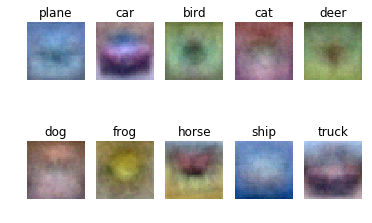

In [29]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])